In [1]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'


In [3]:
import sys
sys.argv.append("-Xfrozen_modules=off")


In [110]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [112]:
# Load Data
df = pd.read_csv("NFHS_5_India_Districts_Factsheet_Data.csv")

# Replace non-numeric values with NaN
df.replace(r'[*()\-,]', '', regex=True, inplace=True)

# Convert all possible columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')


In [114]:
df.head()

,District Names,State/UT,Number of Households surveyed,Number of Women age 15-49 years interviewed,Number of Men age 15-54 years interviewed,Female population age 6 years and above who ever attended school (%),Population below age 15 years (%),"Sex ratio of the total population (females per 1,000 males)","Sex ratio at birth for children born in the last five years (females per 1,000 males)",Children under age 5 years whose birth was registered with the civil authority (%),...,Men age 15 years and above wih Mildly elevated blood pressure (Systolic 140-159 mm of Hg and/or Diastolic 90-99 mm of Hg) (%),Men age 15 years and above wih Moderately or severely elevated blood pressure (Systolic ≥160 mm of Hg and/or Diastolic ≥100 mm of Hg) (%),Men age 15 years and above wih Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%),Women (age 30-49 years) Ever undergone a screening test for cervical cancer (%),Women (age 30-49 years) Ever undergone a breast examination for breast cancer (%),Women (age 30-49 years) Ever undergone an oral cavity examination for oral cancer (%),Women age 15 years and above who use any kind of tobacco (%),Men age 15 years and above who use any kind of tobacco (%),Women age 15 years and above who consume alcohol (%),Men age 15 years and above who consume alcohol (%)
0,NaN,NaN,882,764,125,78.0,23.0,973,927,98.0,...,32.9,11.1,47.0,13.4,13.2,5.4,63.5,76.8,29.6,64.5
1,NaN,NaN,874,789,108,82.7,19.8,950,844,100.0,...,22.6,6.0,32.2,1.7,0.3,15.8,46.8,70.5,5.1,45.3
2,NaN,NaN,868,844,134,84.7,21.0,967,935,96.5,...,17.9,6.1,26.9,1.3,0.7,8.0,19.6,50.8,1.7,32.8
3,NaN,NaN,874,780,100,60.0,20.7,1140,1163,95.0,...,14.4,5.5,22.9,1.0,0.2,3.8,7.1,21.3,0.6,28.3
4,NaN,NaN,902,853,134,56.0,20.6,1114,898,95.4,...,14.8,6.4,25.1,4.9,0.6,7.3,11.4,21.5,0.8,32.3


In [116]:

# Apply KNN Imputer for missing values
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, 2:] = imputer.fit_transform(df.iloc[:, 2:])


In [118]:
# Normalize numeric columns
scaler = MinMaxScaler()
df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])

In [120]:
# Rename target variable
anaemia_col = 'All women age 15-49 years who are anaemic22 (%)'
df.rename(columns={anaemia_col: 'anaemia_rate'}, inplace=True)


In [122]:
print(df.columns.tolist())

['District Names', 'State/UT', 'Number of Households surveyed', 'Number of Women age 15-49 years interviewed', 'Number of Men age 15-54 years interviewed', 'Female population age 6 years and above who ever attended school (%)', 'Population below age 15 years (%)', ' Sex ratio of the total population (females per 1,000 males)', 'Sex ratio at birth for children born in the last five years (females per 1,000 males)', 'Children under age 5 years whose birth was registered with the civil authority (%)', 'Deaths in the last 3 years registered with the civil authority (%)', 'Population living in households with electricity (%)', 'Population living in households with an improved drinking-water source1 (%)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', 'Children age 5 years who attended 

In [124]:
df = df.drop(columns=[col for col in df.columns if "anaemic22" in col], errors='ignore')


In [126]:
print(df.columns.tolist())


['District Names', 'State/UT', 'Number of Households surveyed', 'Number of Women age 15-49 years interviewed', 'Number of Men age 15-54 years interviewed', 'Female population age 6 years and above who ever attended school (%)', 'Population below age 15 years (%)', ' Sex ratio of the total population (females per 1,000 males)', 'Sex ratio at birth for children born in the last five years (females per 1,000 males)', 'Children under age 5 years whose birth was registered with the civil authority (%)', 'Deaths in the last 3 years registered with the civil authority (%)', 'Population living in households with electricity (%)', 'Population living in households with an improved drinking-water source1 (%)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', 'Children age 5 years who attended 

In [128]:
# Check correlation of anaemia-related columns with the target
anaemia_cols = [
    'Non-pregnant women age 15-49 years who are anaemic (<12.0 g/dl)22 (%)',
    'Pregnant women age 15-49 years who are anaemic (<11.0 g/dl)22 (%)',

]

# Compute correlation with target
correlation_with_target = df[anaemia_cols + ['anaemia_rate']].corr()

print(correlation_with_target['anaemia_rate'].sort_values(ascending=False))


anaemia_rate                                                             1.000000
Non-pregnant women age 15-49 years who are anaemic (<12.0 g/dl)22 (%)    0.999306
Pregnant women age 15-49 years who are anaemic (<11.0 g/dl)22 (%)        0.687800
Name: anaemia_rate, dtype: float64


In [130]:
# Feature Selection using Random Forest Importance
X = df.drop(columns=['District Names', 'State/UT', 'anaemia_rate','Non-pregnant women age 15-49 years who are anaemic (<12.0 g/dl)22 (%)','Pregnant women age 15-49 years who are anaemic (<11.0 g/dl)22 (%)', 'All women age 15-19 years who are anaemic22 (%)'], errors='ignore')
y = df['anaemia_rate']


In [132]:
# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
df.head()

,District Names,State/UT,Number of Households surveyed,Number of Women age 15-49 years interviewed,Number of Men age 15-54 years interviewed,Female population age 6 years and above who ever attended school (%),Population below age 15 years (%),"Sex ratio of the total population (females per 1,000 males)","Sex ratio at birth for children born in the last five years (females per 1,000 males)",Children under age 5 years whose birth was registered with the civil authority (%),...,Men age 15 years and above wih Mildly elevated blood pressure (Systolic 140-159 mm of Hg and/or Diastolic 90-99 mm of Hg) (%),Men age 15 years and above wih Moderately or severely elevated blood pressure (Systolic ≥160 mm of Hg and/or Diastolic ≥100 mm of Hg) (%),Men age 15 years and above wih Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%),Women (age 30-49 years) Ever undergone a screening test for cervical cancer (%),Women (age 30-49 years) Ever undergone a breast examination for breast cancer (%),Women (age 30-49 years) Ever undergone an oral cavity examination for oral cancer (%),Women age 15 years and above who use any kind of tobacco (%),Men age 15 years and above who use any kind of tobacco (%),Women age 15 years and above who consume alcohol (%),Men age 15 years and above who consume alcohol (%)
0,NaN,NaN,0.861004,0.390036,0.482143,0.605948,0.202312,0.377816,0.796795,0.958678,...,1.000000,0.550802,0.934343,0.577586,0.904110,0.341772,0.899291,0.948509,0.691589,0.942899
1,NaN,NaN,0.850708,0.407829,0.406250,0.693309,0.109827,0.337955,0.766570,1.000000,...,0.626812,0.278075,0.560606,0.073276,0.020548,1.000000,0.662411,0.863144,0.119159,0.661786
2,NaN,NaN,0.842986,0.446975,0.522321,0.730483,0.144509,0.367418,0.799709,0.927686,...,0.456522,0.283422,0.426768,0.056034,0.047945,0.506329,0.276596,0.596206,0.039720,0.478770
3,NaN,NaN,0.850708,0.401423,0.370536,0.271375,0.135838,0.667244,0.882739,0.896694,...,0.329710,0.251337,0.325758,0.043103,0.013699,0.240506,0.099291,0.196477,0.014019,0.412884
4,NaN,NaN,0.886744,0.453381,0.522321,0.197026,0.132948,0.622184,0.786235,0.904959,...,0.344203,0.299465,0.381313,0.211207,0.041096,0.462025,0.160284,0.199187,0.018692,0.471449


In [136]:
from sklearn.feature_selection import SelectFromModel

In [138]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Fit a RandomForest model for feature selection
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
feature_selector.fit(X_train, y_train)

# Get feature importances
importances = feature_selector.feature_importances_

# Set a threshold
threshold = np.percentile(importances, 50)

# Select features with importance above the threshold
selector = SelectFromModel(feature_selector, threshold=threshold, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_temp)

# Get selected feature names and their importance values
selected_features = X_train.columns[selector.get_support()]
selected_importances = importances[selector.get_support()]

# Create a DataFrame for better visualization
selected_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': selected_importances
}).sort_values(by='Importance', ascending=False)


print(f"Total Selected Features: {len(selected_features)}")
print("Selected Features:", selected_features.tolist())

Total Selected Features: 52
Selected Features: ['Number of Households surveyed', 'Number of Women age 15-49 years interviewed', 'Number of Men age 15-54 years interviewed', ' Sex ratio of the total population (females per 1,000 males)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', 'Children age 5 years who attended pre-primary school during the school year 2019-20 (%)', 'Women age 20-24 years married before age 18 years (%)', 'Births in the 5 years preceding the survey that are third or higher order (%)', 'Women age 15-19 years who were already mothers or pregnant at the time of the survey (%)', 'Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any modern method6 (%)', 'Current Use of Family Planning Methods (Currently Married Women Age 15-49  

In [139]:
X_train.columns = X_train.columns.astype(str)
X_temp.columns = X_temp.columns.astype(str)

In [140]:
X_train.columns = X_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
X_temp.columns = X_temp.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [141]:
print(X_train.columns)


Index(['Number of Households surveyed',
       'Number of Women age 15-49 years interviewed',
       'Number of Men age 15-54 years interviewed',
       'Female population age 6 years and above who ever attended school (%)',
       'Population below age 15 years (%)',
       ' Sex ratio of the total population (females per 1,000 males)',
       'Sex ratio at birth for children born in the last five years (females per 1,000 males)',
       'Children under age 5 years whose birth was registered with the civil authority (%)',
       'Deaths in the last 3 years registered with the civil authority (%)',
       'Population living in households with electricity (%)',
       ...
       'Men age 15 years and above wih Mildly elevated blood pressure (Systolic 140-159 mm of Hg and/or Diastolic 90-99 mm of Hg) (%)',
       'Men age 15 years and above wih Moderately or severely elevated blood pressure (Systolic ≥160 mm of Hg and/or Diastolic ≥100 mm of Hg) (%)',
       'Men age 15 years and above w

In [142]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [143]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [151]:
# Split data into train, validation, and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [153]:
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Hyperparameter optimization using Optuna
best_models = {}
best_params = {}

# Main guard to avoid multiprocessing issues in Colab or Jupyter
if __name__ == "__main__":
    for name, model in {
        'LinearRegression': LinearRegression(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'Extra Trees': ExtraTreesRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }.items():

        if name == 'LinearRegression':
            best_models[name] = model.fit(X_train, y_train)
            print(f"Skipping hyperparameter tuning for {name}")
        else:
            def objective(trial):
                params = {}
                if name == 'DecisionTreeRegressor':
                    params = {
                        'max_depth': trial.suggest_int('max_depth', 5, 50),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                       
                    }
                elif name == 'Random Forest':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'max_depth': trial.suggest_int('max_depth', 10, 50),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    }
                elif name == 'Gradient Boosting':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
                    }
                elif name == 'AdaBoost':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
                        'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])
                    }
                elif name == 'Extra Trees':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'max_depth': trial.suggest_int('max_depth', 10, 50),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),

                    }
                elif name == 'XGBoost':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'gamma': trial.suggest_float('gamma', 0, 5),
                        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
                    }

                model.set_params(**params)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                return r2_score(y_val, y_pred)

            study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
            study.optimize(objective, n_trials=20, n_jobs=1)

            best_models[name] = model.set_params(**study.best_params)
            best_params[name] = study.best_params
            print(f"Best Params for {name}: {study.best_params}")

# Evaluate on test set
print("\nFinal Model Performance After Optuna Hyperparameter Tuning:")
print(f"{'Model':<20}{'R2 Score':<15}{'RMSE':<15}")
print("=" * 50)
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name:<20}{r2:.4f}{rmse:.4f}")


[I 2025-04-05 01:52:06,504] A new study created in memory with name: no-name-e2bb58fe-bbd2-4676-9420-b009c92c155a
[I 2025-04-05 01:52:06,539] Trial 0 finished with value: 0.2788499580948466 and parameters: {'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.2788499580948466.
[I 2025-04-05 01:52:06,580] Trial 1 finished with value: 0.30456255707744273 and parameters: {'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.30456255707744273.
[I 2025-04-05 01:52:06,610] Trial 2 finished with value: 0.3453817664008667 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,645] Trial 3 finished with value: 0.3108415382860361 and parameters: {'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,677] Trial 4 finished with value: 

Skipping hyperparameter tuning for LinearRegression


[I 2025-04-05 01:52:06,758] Trial 6 finished with value: 0.34407256577162015 and parameters: {'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,797] Trial 7 finished with value: 0.3349068190028801 and parameters: {'max_depth': 34, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,830] Trial 8 finished with value: 0.2419340809478936 and parameters: {'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,861] Trial 9 finished with value: 0.28001010550867744 and parameters: {'max_depth': 36, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.3453817664008667.
[I 2025-04-05 01:52:06,914] Trial 10 finished with value: 0.31954309862652486 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial

Best Params for DecisionTreeRegressor: {'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 10}


[I 2025-04-05 01:52:09,092] Trial 0 finished with value: 0.5442777899064436 and parameters: {'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5442777899064436.
[I 2025-04-05 01:52:12,149] Trial 1 finished with value: 0.5529609188336799 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.5529609188336799.
[I 2025-04-05 01:52:20,153] Trial 2 finished with value: 0.5273637434492617 and parameters: {'n_estimators': 500, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.5529609188336799.
[I 2025-04-05 01:52:33,938] Trial 3 finished with value: 0.5764564929417382 and parameters: {'n_estimators': 450, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.5764564929417382.
[I 2025-04-05 01:52:43,161] Trial 4 finished with value: 0.5493838478968665 and parameters

Best Params for Random Forest: {'n_estimators': 250, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 2}


[I 2025-04-05 01:54:32,804] Trial 0 finished with value: 0.5997550225224366 and parameters: {'n_estimators': 250, 'learning_rate': 0.0489204217462482, 'max_depth': 7, 'subsample': 0.986625538899444, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5997550225224366.
[I 2025-04-05 01:54:40,256] Trial 1 finished with value: 0.6105341676208587 and parameters: {'n_estimators': 350, 'learning_rate': 0.09096413680296858, 'max_depth': 5, 'subsample': 0.9909970032436624, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.6105341676208587.
[I 2025-04-05 01:54:50,365] Trial 2 finished with value: 0.6014216224569939 and parameters: {'n_estimators': 300, 'learning_rate': 0.07310462845532036, 'max_depth': 10, 'subsample': 0.956332999004154, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.6105341676208587.
[I 2025-04-05 01:54:54,489] Trial 3 finished with value: 0.6326416101611662 and parameters: {'n_estimators': 

Best Params for Gradient Boosting: {'n_estimators': 400, 'learning_rate': 0.15526327359261088, 'max_depth': 10, 'subsample': 0.6798672095216018, 'min_samples_split': 14, 'min_samples_leaf': 7}


[I 2025-04-05 01:56:34,724] Trial 0 finished with value: 0.49268009438029137 and parameters: {'n_estimators': 100, 'learning_rate': 0.18579992079709237, 'loss': 'linear'}. Best is trial 0 with value: 0.49268009438029137.
[I 2025-04-05 01:56:35,285] Trial 1 finished with value: 0.5263753310986028 and parameters: {'n_estimators': 50, 'learning_rate': 0.9570015112926353, 'loss': 'linear'}. Best is trial 1 with value: 0.5263753310986028.
[I 2025-04-05 01:56:37,632] Trial 2 finished with value: 0.5412664669514888 and parameters: {'n_estimators': 250, 'learning_rate': 0.25170932017327224, 'loss': 'square'}. Best is trial 2 with value: 0.5412664669514888.
[I 2025-04-05 01:56:38,256] Trial 3 finished with value: 0.46960648565038676 and parameters: {'n_estimators': 50, 'learning_rate': 0.2466104393924721, 'loss': 'exponential'}. Best is trial 2 with value: 0.5412664669514888.
[I 2025-04-05 01:56:38,796] Trial 4 finished with value: 0.5053827160623283 and parameters: {'n_estimators': 50, 'learni

Best Params for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.7148822723506221, 'loss': 'exponential'}


[I 2025-04-05 01:57:08,797] Trial 0 finished with value: 0.6271712662365563 and parameters: {'n_estimators': 500, 'max_depth': 36, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6271712662365563.
[I 2025-04-05 01:57:09,758] Trial 1 finished with value: 0.6670774490479756 and parameters: {'n_estimators': 200, 'max_depth': 33, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.6670774490479756.
[I 2025-04-05 01:57:10,472] Trial 2 finished with value: 0.6490348082435756 and parameters: {'n_estimators': 200, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.6670774490479756.
[I 2025-04-05 01:57:11,702] Trial 3 finished with value: 0.6266866145859185 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.6670774490479756.
[I 2025-04-05 01:57:14,618] Trial 4 finished with value: 0.6904623344912297 and paramet

Best Params for Extra Trees: {'n_estimators': 400, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1}


[I 2025-04-05 01:57:53,755] Trial 0 finished with value: -0.009678980894926692 and parameters: {'n_estimators': 350, 'learning_rate': 0.22980047815433144, 'max_depth': 10, 'subsample': 0.6937164009978596, 'colsample_bytree': 0.7480657593694866, 'gamma': 3.798030523879956, 'reg_alpha': 0.3972871808596713, 'reg_lambda': 0.270638016023506, 'min_child_weight': 1}. Best is trial 0 with value: -0.009678980894926692.
[I 2025-04-05 01:57:54,061] Trial 1 finished with value: -0.008078670707325708 and parameters: {'n_estimators': 350, 'learning_rate': 0.2780977163699862, 'max_depth': 3, 'subsample': 0.8689783355617376, 'colsample_bytree': 0.9122308526423271, 'gamma': 4.315737748816408, 'reg_alpha': 0.5923380000553617, 'reg_lambda': 0.7558140995583346, 'min_child_weight': 7}. Best is trial 1 with value: -0.008078670707325708.
[I 2025-04-05 01:57:54,270] Trial 2 finished with value: 0.5548103449554258 and parameters: {'n_estimators': 200, 'learning_rate': 0.22480275528010157, 'max_depth': 7, 'subs

Best Params for XGBoost: {'n_estimators': 250, 'learning_rate': 0.29894984957134574, 'max_depth': 6, 'subsample': 0.9998226640222525, 'colsample_bytree': 0.7219674663953181, 'gamma': 0.050924313002387145, 'reg_alpha': 0.11276501026296493, 'reg_lambda': 0.8740890175614293, 'min_child_weight': 6}

Final Model Performance After Optuna Hyperparameter Tuning:
Model               R2 Score       RMSE           
LinearRegression    0.57480.0914
DecisionTreeRegressor0.33080.1146
Random Forest       0.62820.0855
Gradient Boosting   0.71540.0748
AdaBoost            0.55260.0937
Extra Trees         0.64940.0830
XGBoost             0.49520.0996


In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Split data into train, validation, and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Define models (Linear Regression is included without tuning)
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Hyperparameter grids for RandomizedSearchCV
param_grids = {
    'DecisionTreeRegressor': {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1]
    },
    'Extra Trees': {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10]
    }
}

# Dictionary to store best models and parameters
best_models = {}
best_params = {}

# Hyperparameter tuning with RandomizedSearchCV
for name, model in models.items():
    if name == 'LinearRegression':
        best_models[name] = model.fit(X_train, y_train)
        print(f"Skipping hyperparameter tuning for {name}")
    else:
        print(f"Training {name} with RandomizedSearchCV...")
        random_search = RandomizedSearchCV(
            model, param_grids[name], n_iter=10, cv=3, scoring='r2', verbose=1, n_jobs=-1, random_state=42
        )
        random_search.fit(X_train, y_train)

        # Store best model and parameters
        best_models[name] = random_search.best_estimator_
        best_params[name] = random_search.best_params_

        # Validate on validation set
        val_pred = random_search.best_estimator_.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        print(f"Best Params for {name}: {random_search.best_params_}")
        print(f"Best R2 Score on Validation for {name}: {val_r2}")

# Evaluate on test set
print("\nFinal Model Performance After Random Search Hyperparameter Tuning:")
print(f"{'Model':<20}{'R2 Score':<15}{'RMSE':<15}")
print("=" * 50)
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name:<20}{r2:.4f}{rmse:.4f}")


Skipping hyperparameter tuning for LinearRegression
Training DecisionTreeRegressor with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for DecisionTreeRegressor: {'min_samples_split': 2, 'max_depth': 5}
Best R2 Score on Validation for DecisionTreeRegressor: 0.2909433817435879
Training Random Forest with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for Random Forest: {'n_estimators': 250, 'min_samples_split': 2, 'max_depth': 30}
Best R2 Score on Validation for Random Forest: 0.5806450653285029
Training Gradient Boosting with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for Gradient Boosting: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}
Best R2 Score on Validation for Gradient Boosting: 0.6265721511197297
Training AdaBoost with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for Ad

In [43]:
# Assuming X and y are your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<]", "", regex=True)


In [47]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


In [63]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# Base models
base_models = [
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('et', ExtraTreesRegressor(random_state=42))
]

# Meta-model
meta_model = LinearRegression()

# Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Training the stacked model
stacking_regressor.fit(X_train, y_train)

# Predictions
y_pred = stacking_regressor.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Stacked Model R² Score: {r2:.4f}')
print(f'Stacked Model RMSE: {rmse:.4f}')


Stacked Model R² Score: 0.7322
Stacked Model RMSE: 0.0739


In [59]:
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Voting Regressor with optimized parameters
voting_regressor = VotingRegressor(estimators=[
    ('gb', GradientBoostingRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )),
    ('xgb', XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )),
    ('et', ExtraTreesRegressor(
        n_estimators=300,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=30,
        random_state=42
    ))
])

# Training
voting_regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred_voting = voting_regressor.predict(X_test)
r2_voting = r2_score(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
print(f'Voting Regressor R² Score: {r2_voting:.4f}')
print(f'Voting Regressor RMSE: {rmse_voting:.4f}')


Voting Regressor R² Score: 0.7142
Voting Regressor RMSE: 0.0763


In [57]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

# Bagging Regressor with optimized Gradient Boosting as the base estimator
bagging_regressor = BaggingRegressor(
    estimator=GradientBoostingRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    n_estimators=10,
    random_state=42
)

# Training
bagging_regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred_bagging = bagging_regressor.predict(X_test)
r2_bagging = r2_score(y_test, y_pred_bagging)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
print(f'Bagging Regressor R² Score: {r2_bagging:.4f}')
print(f'Bagging Regressor RMSE: {rmse_bagging:.4f}')


Bagging Regressor R² Score: 0.6794
Bagging Regressor RMSE: 0.0808


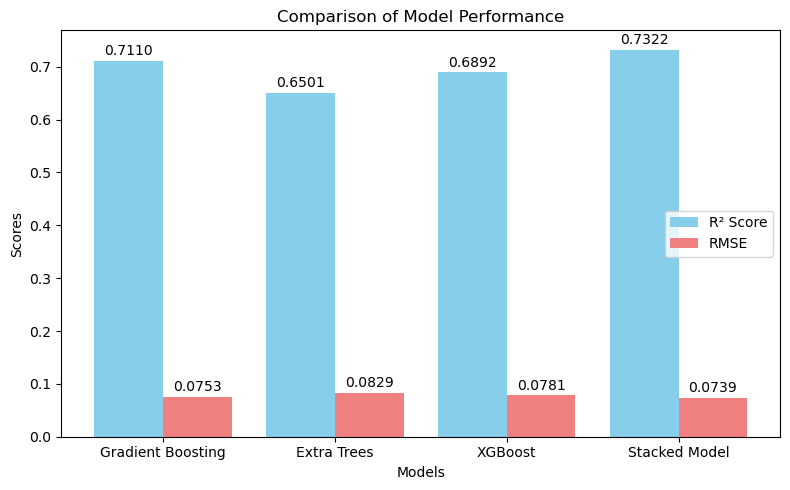

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their R² scores and RMSE values
models = ['Gradient Boosting', 'Extra Trees', 'XGBoost', 'Stacked Model']
r2_scores = [0.7110, 0.6501, 0.6892, 0.7322]
rmse_values = [0.0753, 0.0829, 0.0781, 0.0739]

x = np.arange(len(models))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

# R² scores plot
ax.bar(x - width/2, r2_scores, width, label='R² Score', color='skyblue')

# RMSE values plot
ax.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Displaying the values on top of the bars
for i in range(len(models)):
    ax.text(i - width/2, r2_scores[i] + 0.005, f'{r2_scores[i]:.4f}', ha='center', va='bottom')
    ax.text(i + width/2, rmse_values[i] + 0.005, f'{rmse_values[i]:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


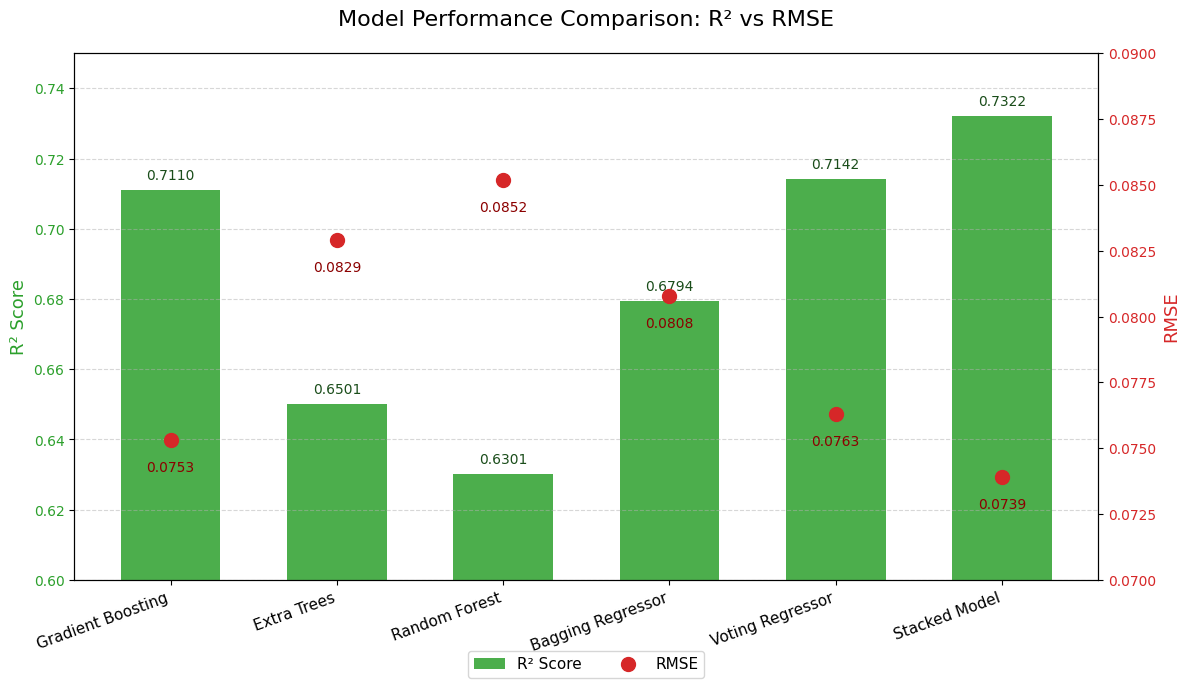

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Gradient Boosting', 'Extra Trees', 'Random Forest', 'Bagging Regressor', 'Voting Regressor', 'Stacked Model']
r2_scores = [0.7110, 0.6501, 0.6301, 0.6794, 0.7142, 0.7322]
rmse_scores = [0.0753, 0.0829, 0.0852, 0.0808, 0.0763, 0.0739]

x = np.arange(len(models))
width = 0.6  # Wider bars

# Plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar plot for R² scores
bars = ax1.bar(x, r2_scores, width=width, color='#2ca02c', alpha=0.85, label='R² Score')
ax1.set_ylabel('R² Score', fontsize=13, color='#2ca02c')
ax1.set_ylim(0.6, 0.75)
ax1.tick_params(axis='y', labelcolor='#2ca02c')

# Line plot with dots for RMSE — placed on top of bars
ax2 = ax1.twinx()
ax2.plot(x, rmse_scores, color='#d62728', marker='o', markersize=10, linestyle='', label='RMSE')
ax2.set_ylabel('RMSE', fontsize=13, color='#d62728')
ax2.set_ylim(0.07, 0.09)
ax2.tick_params(axis='y', labelcolor='#d62728')

# Annotations
for i in range(len(models)):
    ax1.text(x[i], r2_scores[i] + 0.003, f'{r2_scores[i]:.4f}', ha='center', fontsize=10, color='#1a4d1a')
    ax2.text(x[i], rmse_scores[i] - 0.0012, f'{rmse_scores[i]:.4f}', ha='center', fontsize=10, color='#8b0000')

# X-axis
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha='right', fontsize=11)

# Title and grid
ax1.set_title('Model Performance Comparison: R² vs RMSE', fontsize=16, pad=20)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
ax2.grid(False)

# Combine legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=11)

plt.tight_layout()
plt.show()


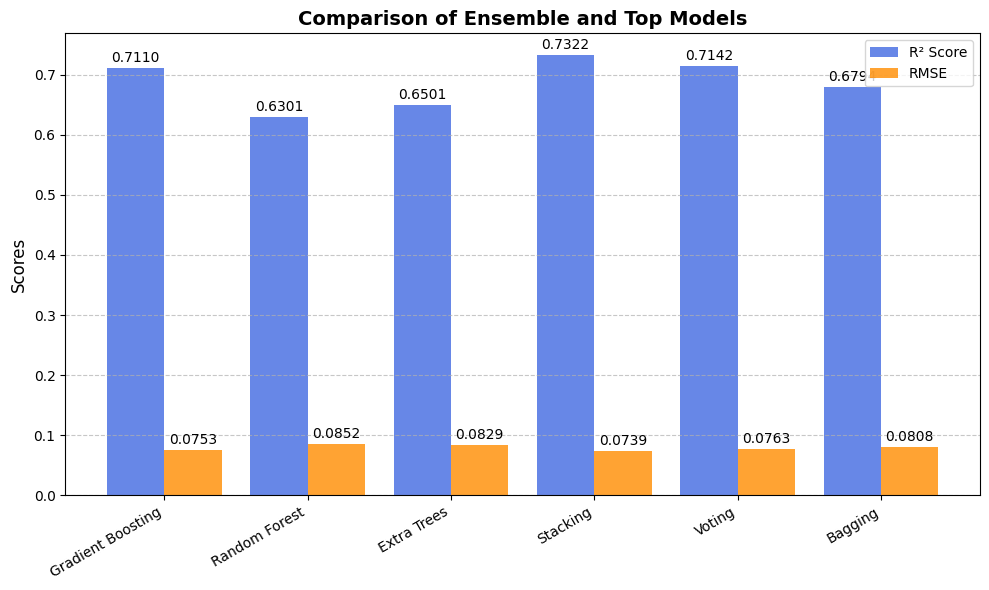

In [190]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
models = ['Gradient Boosting', 'Random Forest', 'Extra Trees', 'Stacking', 'Voting', 'Bagging']
r2_scores = [0.7110, 0.6301, 0.6501, 0.7322, 0.7142, 0.6794]
rmse_scores = [0.0753, 0.0852, 0.0829, 0.0739, 0.0763, 0.0808]

# X positions for bars
x = np.arange(len(models))

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for R² Scores
bar_width = 0.4
ax.bar(x - bar_width/2, r2_scores, bar_width, label='R² Score', color='royalblue', alpha=0.8)

# Bar plot for RMSE Scores
ax.bar(x + bar_width/2, rmse_scores, bar_width, label='RMSE', color='darkorange', alpha=0.8)

# Adding annotations on top of each bar
for i in range(len(models)):
    ax.text(x[i] - bar_width/2, r2_scores[i] + 0.005, f'{r2_scores[i]:.4f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + bar_width/2, rmse_scores[i] + 0.005, f'{rmse_scores[i]:.4f}', ha='center', va='bottom', fontsize=10)

# Customizing the plot
ax.set_title('Comparison of Ensemble and Top Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.set_ylabel('Scores', fontsize=12)
ax.legend()

# Grid and layout adjustments
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

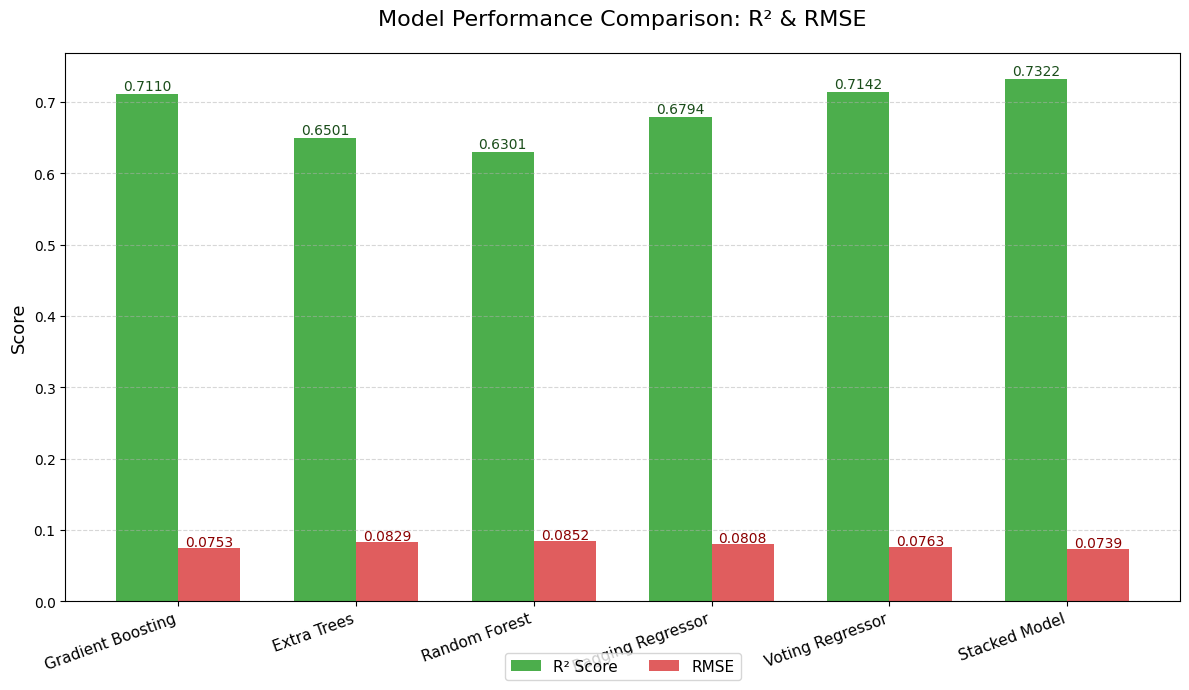

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Gradient Boosting', 'Extra Trees', 'Random Forest', 'Bagging Regressor', 'Voting Regressor', 'Stacked Model']
r2_scores = [0.7110, 0.6501, 0.6301, 0.6794, 0.7142, 0.7322]
rmse_scores = [0.0753, 0.0829, 0.0852, 0.0808, 0.0763, 0.0739]

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Bars for R² and RMSE
r2 = ax.bar(x - width/2, r2_scores, width, label='R² Score', color='#2ca02c', alpha=0.85)
rmse = ax.bar(x + width/2, rmse_scores, width, label='RMSE', color='#d62728', alpha=0.75)

# Labels on top of bars
for i in range(len(models)):
    ax.text(x[i] - width/2, r2_scores[i] + 0.005, f'{r2_scores[i]:.4f}', ha='center', fontsize=10, color='#1a4d1a')
    ax.text(x[i] + width/2, rmse_scores[i] + 0.002, f'{rmse_scores[i]:.4f}', ha='center', fontsize=10, color='#8b0000')

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=20, ha='right', fontsize=11)

# Labels, title, grid
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Model Performance Comparison: R² & RMSE', fontsize=16, pad=20)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=11)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)

plt.show()
